In [1]:
import os
import icrn
import time
import torch
import random
import librosa
import functions
import dataClass
import numpy as np
import numpy as np
import torchsummary
import pandas as pd
import torch.nn as nn
from pesq import pesq
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### Data Import

In [2]:
filepath = "./data_details.csv"
l = 1000
df = functions.read_csv_data(filepath)
df = df.iloc[:l]
print(df.shape)
df.head()

(1000, 17)


,Unnamed: 0,mixed,near_end,far_end1,far_end2,mixed_path,near_end_path,far_end1_path,far_end2_path,near_end_loc,far_end_loc1,far_end_loc2,mic_loc1,room_dim,sample_freq,room_max_order,room_absorption
0,0,1.wav,FAEM0_1.wav,MGJC0_4.wav,MJRK0_3.wav,./data/mixed/1.wav,./data/near_end/FAEM0_1.wav,./data/far_end/MGJC0_4.wav,./data/far_end/MJRK0_3.wav,"[2, 4, 1]","[14, 7, 3]","[10, 1, 4]","[9, 7, 5]","[15, 10, 5]",16000,3,0.2
1,1,2.wav,FAEM0_1.wav,MMCC0_2.wav,MPRK0_1.wav,./data/mixed/2.wav,./data/near_end/FAEM0_1.wav,./data/far_end/MMCC0_2.wav,./data/far_end/MPRK0_1.wav,"[9, 1, 3]","[14, 5, 2]","[10, 5, 4]","[13, 10, 3]","[15, 10, 5]",16000,3,0.2
2,2,3.wav,FAEM0_1.wav,FBAS0_4.wav,MSEM1_2.wav,./data/mixed/3.wav,./data/near_end/FAEM0_1.wav,./data/far_end/FBAS0_4.wav,./data/far_end/MSEM1_2.wav,"[10, 2, 1]","[8, 6, 4]","[3, 2, 2]","[7, 5, 4]","[15, 10, 5]",16000,3,0.2
3,3,4.wav,FAEM0_1.wav,MTJG0_1.wav,MWAR0_3.wav,./data/mixed/4.wav,./data/near_end/FAEM0_1.wav,./data/far_end/MTJG0_1.wav,./data/far_end/MWAR0_3.wav,"[9, 5, 3]","[6, 3, 4]","[8, 9, 4]","[7, 6, 1]","[15, 10, 5]",16000,3,0.2
4,4,5.wav,FAEM0_1.wav,FEEH0_3.wav,MRDS0_2.wav,./data/mixed/5.wav,./data/near_end/FAEM0_1.wav,./data/far_end/FEEH0_3.wav,./data/far_end/MRDS0_2.wav,"[9, 4, 3]","[4, 7, 1]","[12, 2, 4]","[5, 1, 1]","[15, 10, 5]",16000,3,0.2


In [3]:
mixed = df['mixed_path'].tolist()
far1 = df['far_end1_path'].tolist()
far2 = df['far_end2_path'].tolist()
near = df['near_end_path'].tolist()
print(len(near), len(far1), len(far2), len(mixed))

1000 1000 1000 1000


## Base Paper

In [9]:
def train(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase, near_wave in train_loader:
            combined_input = torch.cat((far1.unsqueeze(1), far2.unsqueeze(1), mixed.unsqueeze(1)), dim=1) # [batch_size, 3, 257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input).squeeze(1)
            loss = criterion(outputs, near)
            loss.backward()
            optimizer.step()
        
        near_phase = near_phase.cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        erle_avg, pesq_avg = functions.erle_pesq(outputs, near_wave, near_phase)
        erle_arr.append(erle_avg)
        pesq_arr.append(pesq_avg)
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}, ERLE Score: {erle_avg:.2f}, PESQ Score: {pesq_avg:.2f}")



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = icrn.Model(in_channels=3, out_channels=1).to(device)
summary(base_model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─ModuleList: 1-1                        --
│    └─InplaceConvBlock: 2-1             --
│    │    └─Conv2d: 3-1                  672
│    │    └─BatchNorm2d: 3-2             48
│    │    └─ELU: 3-3                     --
│    └─InplaceConvBlock: 2-2             --
│    │    └─Conv2d: 3-4                  5,208
│    │    └─BatchNorm2d: 3-5             48
│    │    └─ELU: 3-6                     --
│    └─InplaceConvBlock: 2-3             --
│    │    └─Conv2d: 3-7                  5,208
│    │    └─BatchNorm2d: 3-8             48
│    │    └─ELU: 3-9                     --
│    └─InplaceConvBlock: 2-4             --
│    │    └─Conv2d: 3-10                 5,208
│    │    └─BatchNorm2d: 3-11            48
│    │    └─ELU: 3-12                    --
│    └─InplaceConvBlock: 2-5             --
│    │    └─Conv2d: 3-13                 5,208
│    │    └─BatchNorm2d: 3-14            48
│    │    └─EL

In [6]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
train(base_model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0027, Duration: 3 minutes 28 seconds, ERLE Score: 24.11, PESQ Score: 1.22
[Epoch   2/40] Train Loss: 0.0014, Duration: 3 minutes 26 seconds, ERLE Score: 25.49, PESQ Score: 1.16
[Epoch   3/40] Train Loss: 0.0022, Duration: 3 minutes 25 seconds, ERLE Score: 25.62, PESQ Score: 1.24
[Epoch   4/40] Train Loss: 0.0010, Duration: 3 minutes 25 seconds, ERLE Score: 24.09, PESQ Score: 1.28
[Epoch   5/40] Train Loss: 0.0012, Duration: 3 minutes 25 seconds, ERLE Score: 24.28, PESQ Score: 1.45
[Epoch   6/40] Train Loss: 0.0019, Duration: 3 minutes 25 seconds, ERLE Score: 24.51, PESQ Score: 1.34
[Epoch   7/40] Train Loss: 0.0015, Duration: 3 minutes 25 seconds, ERLE Score: 25.92, PESQ Score: 1.46
[Epoch   8/40] Train Loss: 0.0019, Duration: 3 minutes 25 seconds, ERLE Score: 25.52, PESQ Score: 1.45
[Epoch   9/40] Train Loss: 0.0007, Duration: 3 minutes 25 seconds, ERLE Score: 24.18, PESQ Score: 1.39
[Epoch  10/40] Train Loss: 0.0037, Duration: 3 minutes 25 seconds, ERLE S

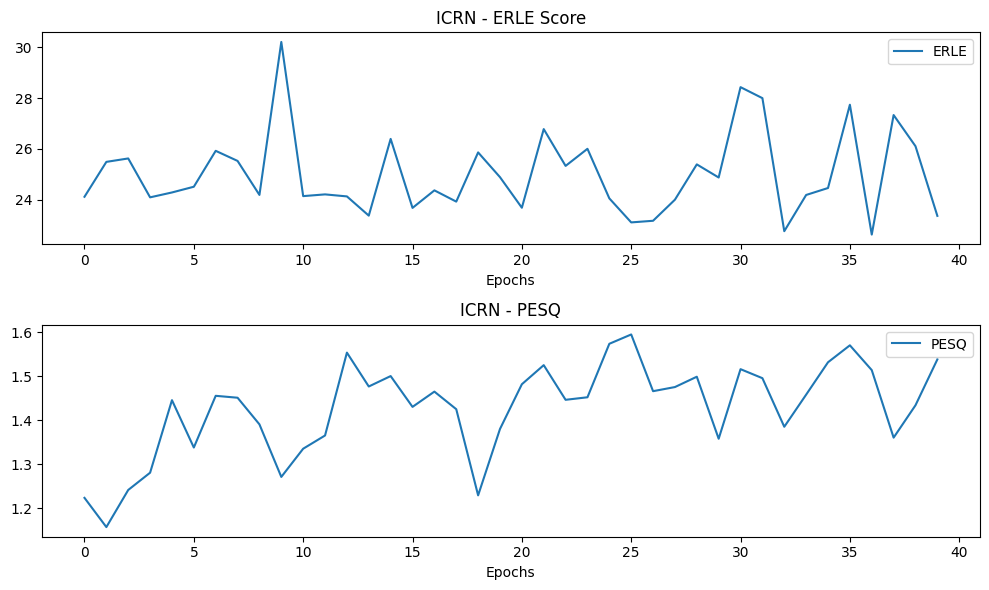

In [8]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("ICRN - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("ICRN - PESQ Score")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
torch.save(base_model, "./models/ICRN.pth")

In [3]:
# model = torch.load("./models/ICRN.pth")
model = model.to('cuda') 
model.eval()


EchoCancelCNN(
  (conv1): Conv2d(3, 8, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [10]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase, _) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = torch.cat((far_mag1.unsqueeze(axis), far_mag2.unsqueeze(axis), mixed_mag.unsqueeze(axis)), axis=axis)
combined_input.shape

torch.Size([3, 257, 512])

In [11]:
outputs = base_model(combined_input.unsqueeze(0).to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="ICRN", n_fft=512, hop_length=256, sr=16000, write=0)


array([ 5.5876775e-05, -2.8959434e-05,  5.8311685e-05, ...,
       -7.1165246e-05,  7.7587201e-06, -8.7346736e-05], dtype=float32)

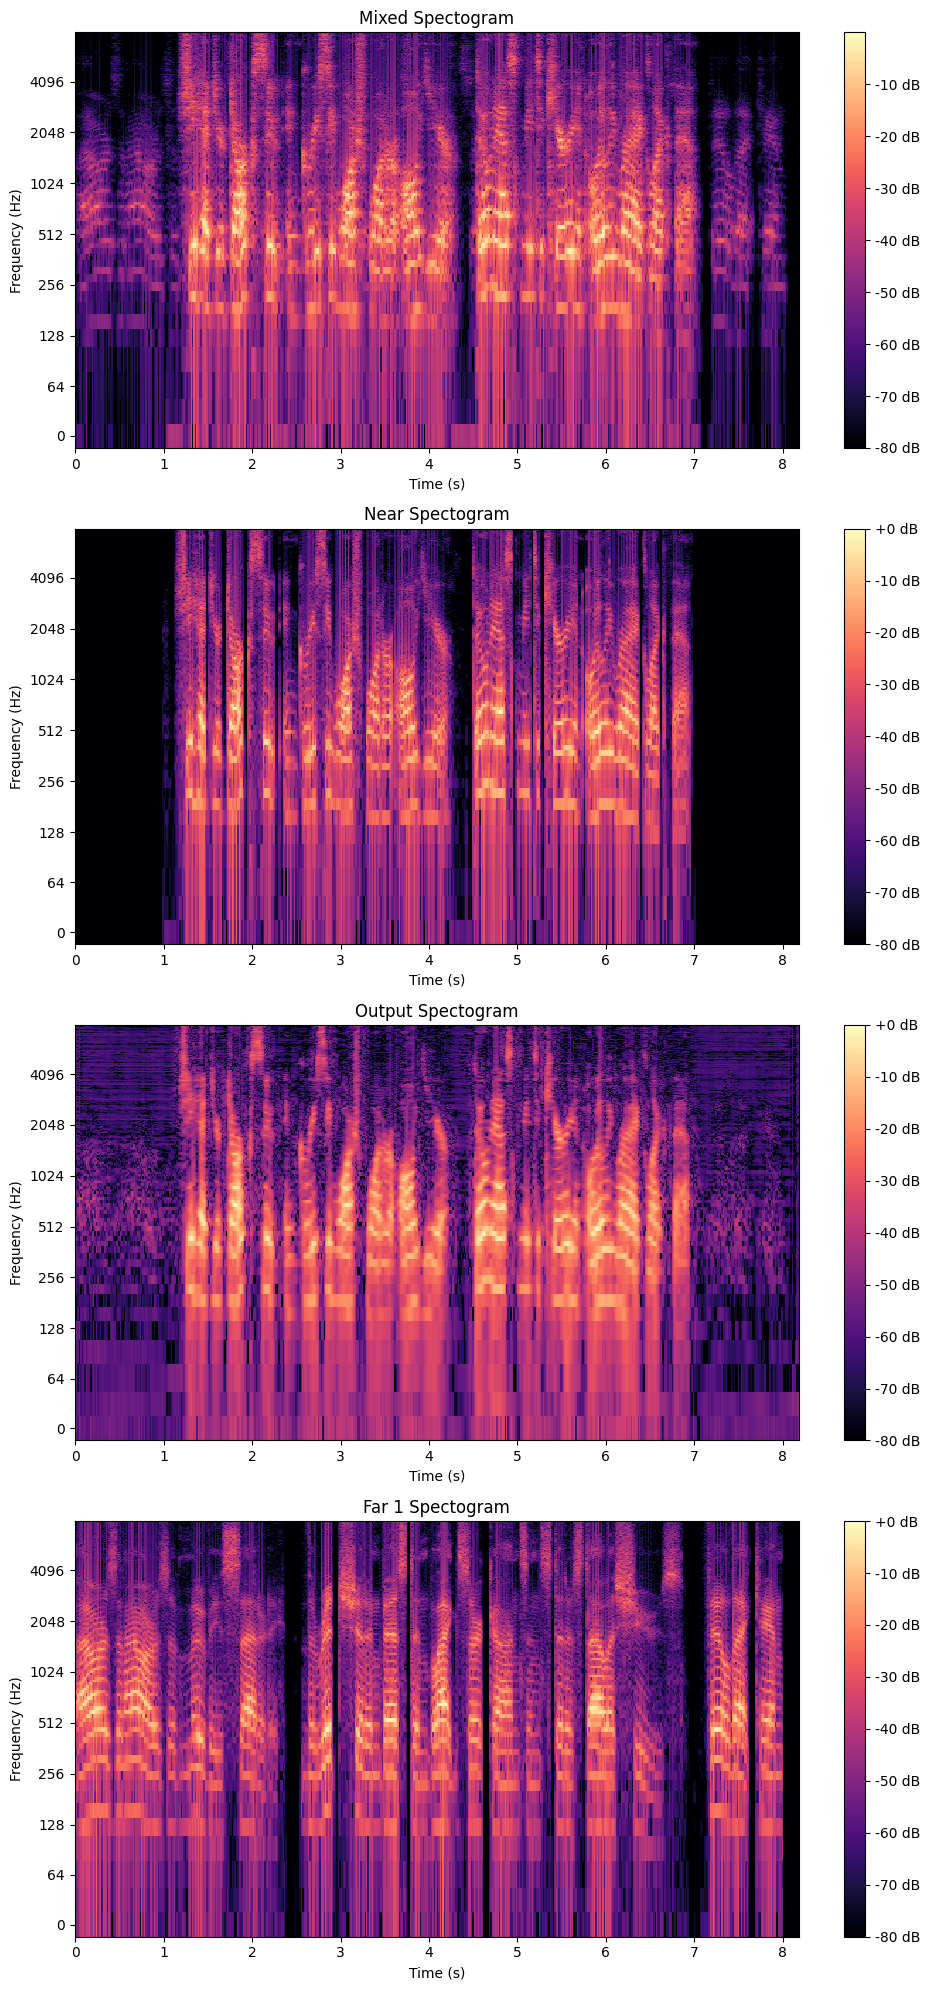

In [12]:
data = [mixed_mag, near_mag, outputs, far_mag1]
titles = ["Mixed Spectogram", "Near Spectogram", "Output Spectogram", "Far 1 Spectogram"]

functions.plot_spectograms(data, titles)

## UNET LSTM 

In [4]:
def train_UNet(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    smooth_l1_loss_criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase, near_wave in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            sisnr = functions.sisnr_loss(outputs, near)
            smooth_l1_loss = smooth_l1_loss_criterion(outputs, near)
            smooth_l1_loss.backward()
            optimizer.step()
            total_loss += smooth_l1_loss.item()
        
        near_phase = near_phase.cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        
        erle_avg, pesq_avg = functions.erle_pesq(outputs, near_wave, near_phase)
        erle_arr.append(erle_avg)
        pesq_arr.append(pesq_avg)
        
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {total_loss/len(train_loader):.4f}, Duration: {duration}, ERLE Score: {erle_avg:.2f}, PESQ Score: {pesq_avg:.2f}")


##### UNET_LSTM_BN reduced layers by 0.1 factor

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [5]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = UNet(features = [51, 76, 102, 128]).to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 51, 512]              --
│    └─Conv1d: 2-1                       [1, 51, 512]              118,014
│    └─ReLU: 2-2                         [1, 51, 512]              --
│    └─Conv1d: 2-3                       [1, 51, 512]              7,854
│    └─BatchNorm1d: 2-4                  [1, 51, 512]              102
│    └─ReLU: 2-5                         [1, 51, 512]              --
├─MaxPool1d: 1-2                         [1, 51, 256]              --
├─Sequential: 1-3                        [1, 76, 256]              --
│    └─Conv1d: 2-6                       [1, 76, 256]              11,704
│    └─ReLU: 2-7                         [1, 76, 256]              --
│    └─Conv1d: 2-8                       [1, 76, 256]              17,404
│    └─BatchNorm1d: 2-9                  [1, 76, 256]              1

In [12]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0014, Duration: 49 seconds, ERLE Score: 30.94, PESQ Score: 1.03
[Epoch   2/40] Train Loss: 0.0007, Duration: 16 seconds, ERLE Score: 28.10, PESQ Score: 1.03
[Epoch   3/40] Train Loss: 0.0013, Duration: 16 seconds, ERLE Score: 34.43, PESQ Score: 1.04
[Epoch   4/40] Train Loss: 0.0013, Duration: 16 seconds, ERLE Score: 28.28, PESQ Score: 1.04
[Epoch   5/40] Train Loss: 0.0010, Duration: 16 seconds, ERLE Score: 32.20, PESQ Score: 1.06
[Epoch   6/40] Train Loss: 0.0012, Duration: 16 seconds, ERLE Score: 30.18, PESQ Score: 1.05
[Epoch   7/40] Train Loss: 0.0013, Duration: 16 seconds, ERLE Score: 32.56, PESQ Score: 1.05
[Epoch   8/40] Train Loss: 0.0006, Duration: 16 seconds, ERLE Score: 28.04, PESQ Score: 1.08
[Epoch   9/40] Train Loss: 0.0005, Duration: 16 seconds, ERLE Score: 27.00, PESQ Score: 1.10
[Epoch  10/40] Train Loss: 0.0010, Duration: 15 seconds, ERLE Score: 31.21, PESQ Score: 1.08
[Epoch  11/40] Train Loss: 0.0014, Duration: 15 seconds, ERLE Score: 3

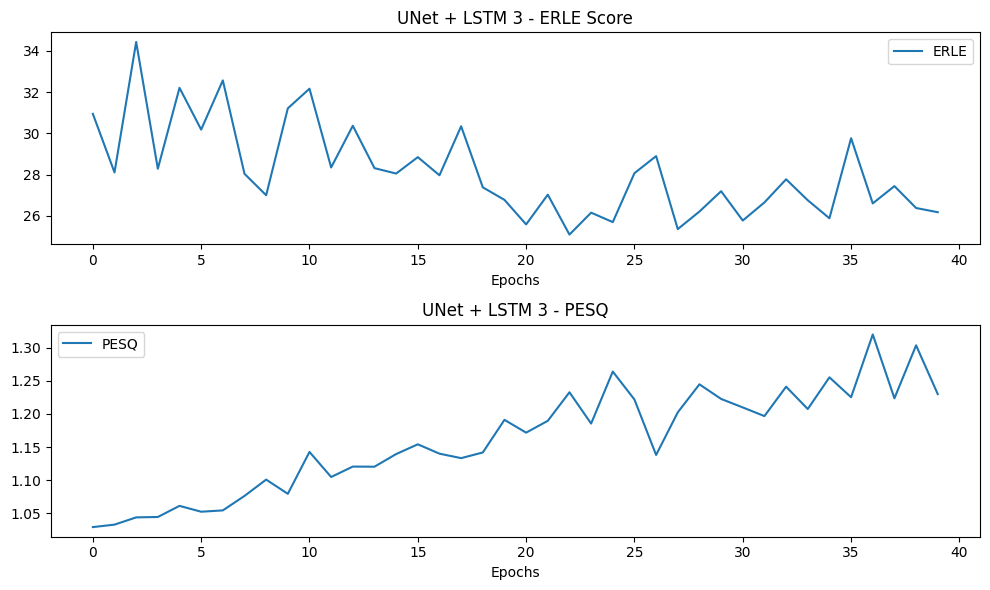

In [13]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### UNET_LSTM_BN reduced layers by 0.4 factor

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet(features = [205, 308, 4097, 512]).to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 205, 512]             --
│    └─Conv1d: 2-1                       [1, 205, 512]             474,370
│    └─ReLU: 2-2                         [1, 205, 512]             --
│    └─Conv1d: 2-3                       [1, 205, 512]             126,280
│    └─BatchNorm1d: 2-4                  [1, 205, 512]             410
│    └─ReLU: 2-5                         [1, 205, 512]             --
├─MaxPool1d: 1-2                         [1, 205, 256]             --
├─Sequential: 1-3                        [1, 308, 256]             --
│    └─Conv1d: 2-6                       [1, 308, 256]             189,728
│    └─ReLU: 2-7                         [1, 308, 256]             --
│    └─Conv1d: 2-8                       [1, 308, 256]             284,900
│    └─BatchNorm1d: 2-9                  [1, 308, 256]          

In [8]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0018, Duration: 1 minutes 0 seconds, ERLE Score: 33.46, PESQ Score: 1.04
[Epoch   2/40] Train Loss: 0.0016, Duration: 51 seconds, ERLE Score: 31.24, PESQ Score: 1.06
[Epoch   3/40] Train Loss: 0.0011, Duration: 51 seconds, ERLE Score: 28.50, PESQ Score: 1.08
[Epoch   4/40] Train Loss: 0.0012, Duration: 51 seconds, ERLE Score: 30.40, PESQ Score: 1.12
[Epoch   5/40] Train Loss: 0.0010, Duration: 51 seconds, ERLE Score: 26.25, PESQ Score: 1.10
[Epoch   6/40] Train Loss: 0.0012, Duration: 51 seconds, ERLE Score: 29.32, PESQ Score: 1.15
[Epoch   7/40] Train Loss: 0.0005, Duration: 51 seconds, ERLE Score: 24.97, PESQ Score: 1.19
[Epoch   8/40] Train Loss: 0.0005, Duration: 51 seconds, ERLE Score: 25.29, PESQ Score: 1.20
[Epoch   9/40] Train Loss: 0.0009, Duration: 51 seconds, ERLE Score: 27.84, PESQ Score: 1.19
[Epoch  10/40] Train Loss: 0.0004, Duration: 51 seconds, ERLE Score: 25.73, PESQ Score: 1.22
[Epoch  11/40] Train Loss: 0.0008, Duration: 51 seconds, ERLE

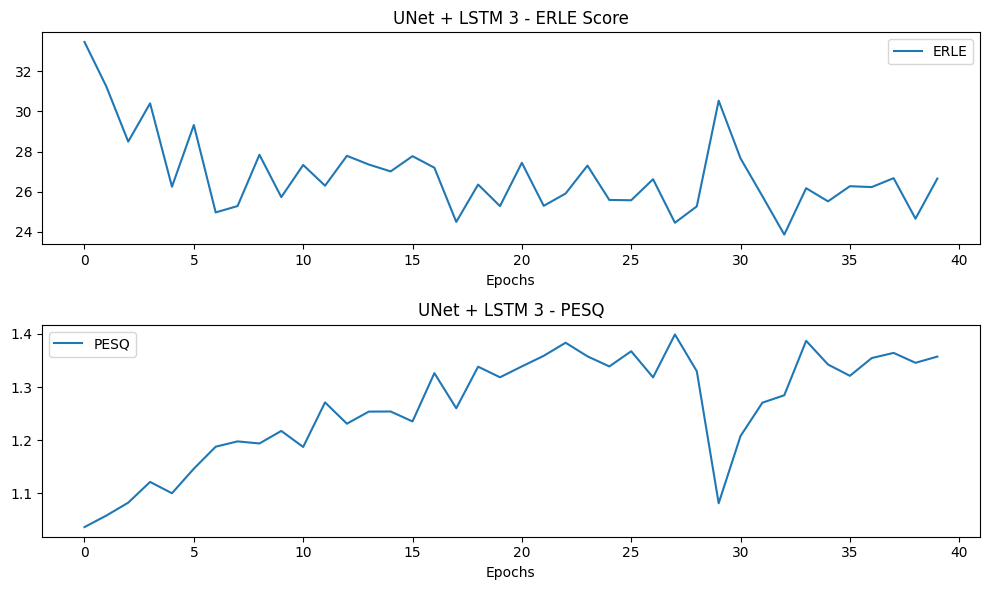

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### UNET_LSTM_BN reduced layers by 0.8 factor

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet(features = [410, 614, 819, 1024]).to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 410, 512]             --
│    └─Conv1d: 2-1                       [1, 410, 512]             948,740
│    └─ReLU: 2-2                         [1, 410, 512]             --
│    └─Conv1d: 2-3                       [1, 410, 512]             504,710
│    └─BatchNorm1d: 2-4                  [1, 410, 512]             820
│    └─ReLU: 2-5                         [1, 410, 512]             --
├─MaxPool1d: 1-2                         [1, 410, 256]             --
├─Sequential: 1-3                        [1, 614, 256]             --
│    └─Conv1d: 2-6                       [1, 614, 256]             755,834
│    └─ReLU: 2-7                         [1, 614, 256]             --
│    └─Conv1d: 2-8                       [1, 614, 256]             1,131,602
│    └─BatchNorm1d: 2-9                  [1, 614, 256]        

In [8]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0011, Duration: 28 seconds, ERLE Score: 31.06, PESQ Score: 1.05
[Epoch   2/40] Train Loss: 0.0021, Duration: 26 seconds, ERLE Score: 33.26, PESQ Score: 1.08
[Epoch   3/40] Train Loss: 0.0009, Duration: 26 seconds, ERLE Score: 28.44, PESQ Score: 1.12
[Epoch   4/40] Train Loss: 0.0011, Duration: 26 seconds, ERLE Score: 25.54, PESQ Score: 1.20
[Epoch   5/40] Train Loss: 0.0009, Duration: 26 seconds, ERLE Score: 27.68, PESQ Score: 1.17
[Epoch   6/40] Train Loss: 0.0007, Duration: 26 seconds, ERLE Score: 24.78, PESQ Score: 1.20
[Epoch   7/40] Train Loss: 0.0007, Duration: 26 seconds, ERLE Score: 26.43, PESQ Score: 1.23
[Epoch   8/40] Train Loss: 0.0006, Duration: 26 seconds, ERLE Score: 25.08, PESQ Score: 1.22
[Epoch   9/40] Train Loss: 0.0011, Duration: 26 seconds, ERLE Score: 28.79, PESQ Score: 1.24
[Epoch  10/40] Train Loss: 0.0008, Duration: 26 seconds, ERLE Score: 27.35, PESQ Score: 1.09
[Epoch  11/40] Train Loss: 0.0008, Duration: 26 seconds, ERLE Score: 2

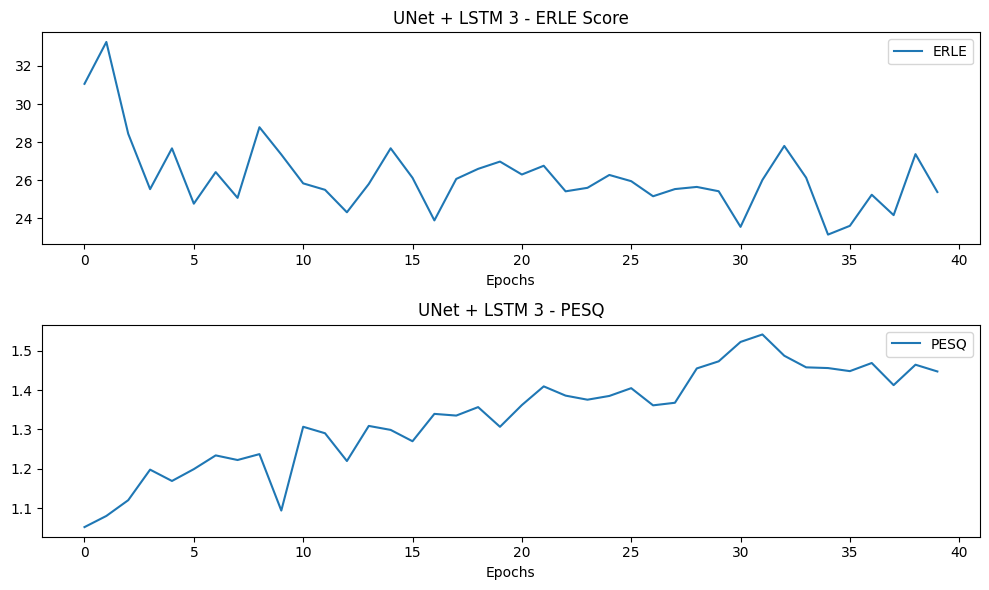

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### UNET_FreqLSTM

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        # self.LSTM = nn.LSTM(, , num_layers=2, batch_first=True)
        self.frequency_lstm = icrn.FrequencyWiseLSTM(features[3], self.hidden_size)
        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, T, features)
        bottleneck = self.frequency_lstm(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck.transpose(1,2) # (batch, features, T)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet(features = [410, 614, 819, 1024]).to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 410, 512]             --
│    └─Conv1d: 2-1                       [1, 410, 512]             948,740
│    └─ReLU: 2-2                         [1, 410, 512]             --
│    └─Conv1d: 2-3                       [1, 410, 512]             504,710
│    └─BatchNorm1d: 2-4                  [1, 410, 512]             820
│    └─ReLU: 2-5                         [1, 410, 512]             --
├─MaxPool1d: 1-2                         [1, 410, 256]             --
├─Sequential: 1-3                        [1, 614, 256]             --
│    └─Conv1d: 2-6                       [1, 614, 256]             755,834
│    └─ReLU: 2-7                         [1, 614, 256]             --
│    └─Conv1d: 2-8                       [1, 614, 256]             1,131,602
│    └─BatchNorm1d: 2-9                  [1, 614, 256]        

In [8]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0012, Duration: 30 seconds, ERLE Score: 30.47, PESQ Score: 1.06
[Epoch   2/40] Train Loss: 0.0008, Duration: 21 seconds, ERLE Score: 29.37, PESQ Score: 1.08
[Epoch   3/40] Train Loss: 0.0009, Duration: 21 seconds, ERLE Score: 27.01, PESQ Score: 1.16
[Epoch   4/40] Train Loss: 0.0007, Duration: 21 seconds, ERLE Score: 26.85, PESQ Score: 1.18
[Epoch   5/40] Train Loss: 0.0009, Duration: 21 seconds, ERLE Score: 28.50, PESQ Score: 1.20
[Epoch   6/40] Train Loss: 0.0008, Duration: 20 seconds, ERLE Score: 27.04, PESQ Score: 1.20
[Epoch   7/40] Train Loss: 0.0014, Duration: 21 seconds, ERLE Score: 28.51, PESQ Score: 1.06
[Epoch   8/40] Train Loss: 0.0006, Duration: 21 seconds, ERLE Score: 26.81, PESQ Score: 1.22
[Epoch   9/40] Train Loss: 0.0003, Duration: 21 seconds, ERLE Score: 24.69, PESQ Score: 1.26
[Epoch  10/40] Train Loss: 0.0012, Duration: 20 seconds, ERLE Score: 27.46, PESQ Score: 1.36
[Epoch  11/40] Train Loss: 0.0005, Duration: 21 seconds, ERLE Score: 2

In [9]:
train_UNet(model, train_loader, num_epochs=20, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/20] Train Loss: 0.0007, Duration: 21 seconds, ERLE Score: 25.79, PESQ Score: 1.48
[Epoch   2/20] Train Loss: 0.0003, Duration: 20 seconds, ERLE Score: 23.62, PESQ Score: 1.52
[Epoch   3/20] Train Loss: 0.0006, Duration: 20 seconds, ERLE Score: 24.84, PESQ Score: 1.51
[Epoch   4/20] Train Loss: 0.0003, Duration: 20 seconds, ERLE Score: 25.94, PESQ Score: 1.48
[Epoch   5/20] Train Loss: 0.0005, Duration: 20 seconds, ERLE Score: 25.67, PESQ Score: 1.27
[Epoch   6/20] Train Loss: 0.0006, Duration: 20 seconds, ERLE Score: 26.45, PESQ Score: 1.51
[Epoch   7/20] Train Loss: 0.0004, Duration: 20 seconds, ERLE Score: 24.40, PESQ Score: 1.57
[Epoch   8/20] Train Loss: 0.0004, Duration: 20 seconds, ERLE Score: 25.69, PESQ Score: 1.50
[Epoch   9/20] Train Loss: 0.0003, Duration: 20 seconds, ERLE Score: 25.00, PESQ Score: 1.56
[Epoch  10/20] Train Loss: 0.0011, Duration: 21 seconds, ERLE Score: 31.20, PESQ Score: 1.06
[Epoch  11/20] Train Loss: 0.0013, Duration: 21 seconds, ERLE Score: 3

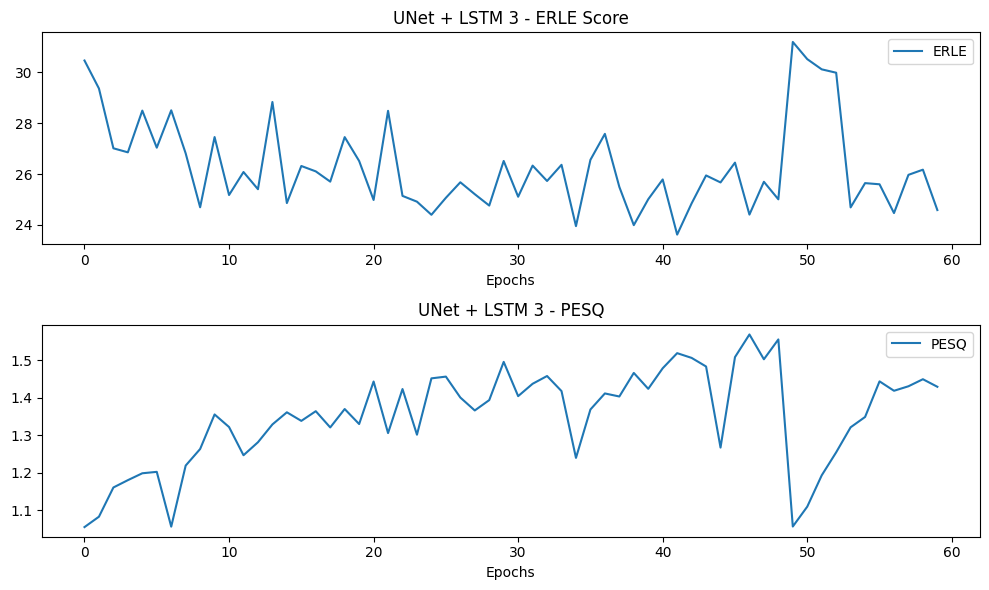

In [10]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### UNET_FreqLSTM_BN_5Layers

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350, 400]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)
        self.encoder_conv5 = self._double_conv(features[3], features[4])
        self.encoder_pool5 = nn.MaxPool1d(2)

        # Bottleneck
        self.frequency_lstm = icrn.FrequencyWiseLSTM(features[4], self.hidden_size)
        
        # Decoder (Upsampling path)
        self.decoder_up5 = nn.ConvTranspose1d(features[4] * 2, features[4], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv5 = self._double_conv(features[4] * 2, features[3])
        self.decoder_up4 = nn.ConvTranspose1d(features[3], features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3] * 2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2] * 2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1] * 2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0] * 2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        enc5 = self.encoder_conv5(pool4)
        pool5 = self.encoder_pool5(enc5)
        
        # # Bottleneck
        pool5_T = pool5.transpose(1, 2) # (batch, T, features)
        bottleneck = self.frequency_lstm(pool5_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck.transpose(1,2) # (batch, features, T)
        
        # # Decoder with skip connections
        dec5 = self.decoder_up5(bottleneck_T)
        dec5 = self.decoder_conv5(torch.cat([dec5, enc5], dim=1))  # Concatenate skip connection
        dec4 = self.decoder_up4(dec5)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [12]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 200, 512]             --
│    └─Conv1d: 2-1                       [1, 200, 512]             462,800
│    └─BatchNorm1d: 2-2                  [1, 200, 512]             400
│    └─ReLU: 2-3                         [1, 200, 512]             --
│    └─Conv1d: 2-4                       [1, 200, 512]             120,200
│    └─BatchNorm1d: 2-5                  [1, 200, 512]             400
│    └─ReLU: 2-6                         [1, 200, 512]             --
├─MaxPool1d: 1-2                         [1, 200, 256]             --
├─Sequential: 1-3                        [1, 250, 256]             --
│    └─Conv1d: 2-7                       [1, 250, 256]             150,250
│    └─BatchNorm1d: 2-8                  [1, 250, 256]             500
│    └─ReLU: 2-9                         [1, 250, 256]             

In [ ]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.0030, Duration: 13 seconds, ERLE Score: 29.42, PESQ Score: 1.06
[Epoch   2/40] Train Loss: 0.0012, Duration: 13 seconds, ERLE Score: 28.53, PESQ Score: 1.07
[Epoch   3/40] Train Loss: 0.0010, Duration: 20 seconds, ERLE Score: 26.44, PESQ Score: 1.11
[Epoch   4/40] Train Loss: 0.0009, Duration: 12 seconds, ERLE Score: 28.51, PESQ Score: 1.13
[Epoch   5/40] Train Loss: 0.0008, Duration: 12 seconds, ERLE Score: 26.20, PESQ Score: 1.17
[Epoch   6/40] Train Loss: 0.0008, Duration: 12 seconds, ERLE Score: 26.19, PESQ Score: 1.20
[Epoch   7/40] Train Loss: 0.0007, Duration: 12 seconds, ERLE Score: 24.19, PESQ Score: 1.24
[Epoch   8/40] Train Loss: 0.0007, Duration: 12 seconds, ERLE Score: 27.57, PESQ Score: 1.19
[Epoch   9/40] Train Loss: 0.0007, Duration: 15 seconds, ERLE Score: 25.07, PESQ Score: 1.23
[Epoch  10/40] Train Loss: 0.0007, Duration: 13 seconds, ERLE Score: 25.85, PESQ Score: 1.25
[Epoch  11/40] Train Loss: 0.0006, Duration: 14 seconds, ERLE Score: 2

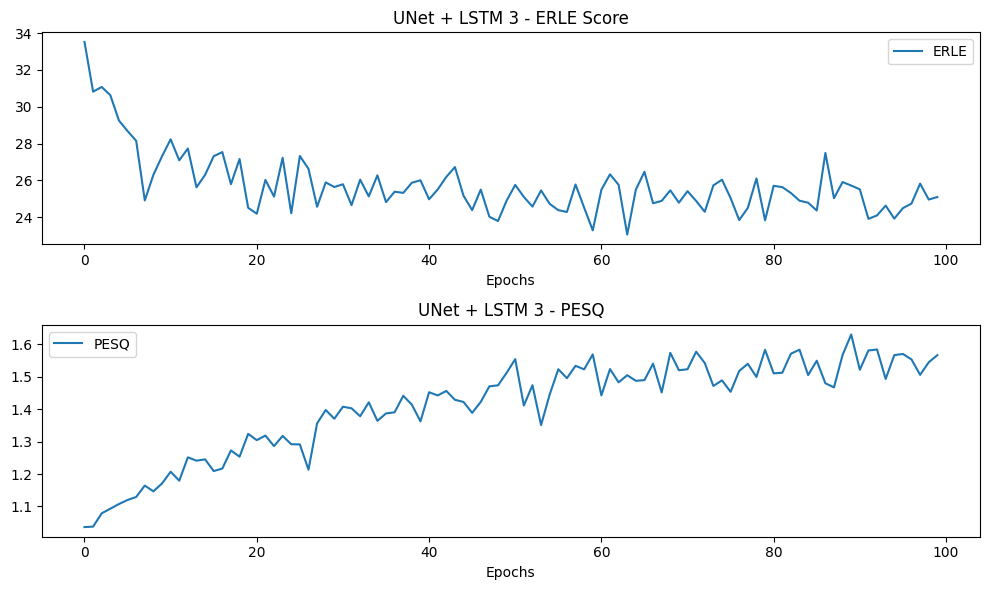

In [13]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### SISNR Ratio + SmoothL1Loss

In [4]:
def train_UNet(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    smooth_l1_loss_criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase, near_wave in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            sisnr = functions.sisnr_loss(outputs, near)
            smooth_l1_loss = smooth_l1_loss_criterion(outputs, near)
            loss = (smooth_l1_loss * 0.5) + (sisnr * 0.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        near_phase = near_phase.cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        
        erle_avg, pesq_avg = functions.erle_pesq(outputs, near_wave, near_phase)
        erle_arr.append(erle_avg)
        pesq_arr.append(pesq_avg)
        
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {total_loss/len(train_loader):.4f}, Duration: {duration}, ERLE Score: {erle_avg:.2f}, PESQ Score: {pesq_avg:.2f}")


In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350, 400]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)
        self.encoder_conv5 = self._double_conv(features[3], features[4])
        self.encoder_pool5 = nn.MaxPool1d(2)

        # Bottleneck
        self.frequency_lstm = icrn.FrequencyWiseLSTM(features[4], self.hidden_size)
        
        # Decoder (Upsampling path)
        self.decoder_up5 = nn.ConvTranspose1d(features[4] * 2, features[4], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv5 = self._double_conv(features[4] * 2, features[3])
        self.decoder_up4 = nn.ConvTranspose1d(features[3], features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3] * 2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2] * 2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1] * 2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0] * 2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        enc5 = self.encoder_conv5(pool4)
        pool5 = self.encoder_pool5(enc5)
        
        # # Bottleneck
        pool5_T = pool5.transpose(1, 2) # (batch, T, features)
        bottleneck = self.frequency_lstm(pool5_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck.transpose(1,2) # (batch, features, T)
        
        # # Decoder with skip connections
        dec5 = self.decoder_up5(bottleneck_T)
        dec5 = self.decoder_conv5(torch.cat([dec5, enc5], dim=1))  # Concatenate skip connection
        dec4 = self.decoder_up4(dec5)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 200, 512]             --
│    └─Conv1d: 2-1                       [1, 200, 512]             462,800
│    └─BatchNorm1d: 2-2                  [1, 200, 512]             400
│    └─ReLU: 2-3                         [1, 200, 512]             --
│    └─Conv1d: 2-4                       [1, 200, 512]             120,200
│    └─BatchNorm1d: 2-5                  [1, 200, 512]             400
│    └─ReLU: 2-6                         [1, 200, 512]             --
├─MaxPool1d: 1-2                         [1, 200, 256]             --
├─Sequential: 1-3                        [1, 250, 256]             --
│    └─Conv1d: 2-7                       [1, 250, 256]             150,250
│    └─BatchNorm1d: 2-8                  [1, 250, 256]             500
│    └─ReLU: 2-9                         [1, 250, 256]             

In [8]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: 0.2052, Duration: 1 minutes 0 seconds, ERLE Score: 8.14, PESQ Score: 1.06
[Epoch   2/40] Train Loss: -0.8587, Duration: 12 seconds, ERLE Score: 4.88, PESQ Score: 1.13
[Epoch   3/40] Train Loss: -1.4696, Duration: 12 seconds, ERLE Score: 7.20, PESQ Score: 1.17
[Epoch   4/40] Train Loss: -1.5626, Duration: 12 seconds, ERLE Score: 9.32, PESQ Score: 1.18
[Epoch   5/40] Train Loss: -1.6591, Duration: 12 seconds, ERLE Score: 9.75, PESQ Score: 1.21
[Epoch   6/40] Train Loss: -2.0808, Duration: 12 seconds, ERLE Score: 7.18, PESQ Score: 1.29
[Epoch   7/40] Train Loss: -2.3827, Duration: 15 seconds, ERLE Score: 8.10, PESQ Score: 1.30
[Epoch   8/40] Train Loss: -2.7448, Duration: 35 seconds, ERLE Score: 7.11, PESQ Score: 1.34
[Epoch   9/40] Train Loss: -2.4256, Duration: 12 seconds, ERLE Score: 10.40, PESQ Score: 1.36
[Epoch  10/40] Train Loss: -2.1177, Duration: 14 seconds, ERLE Score: 9.23, PESQ Score: 1.30
[Epoch  11/40] Train Loss: -2.1502, Duration: 15 seconds, ERL

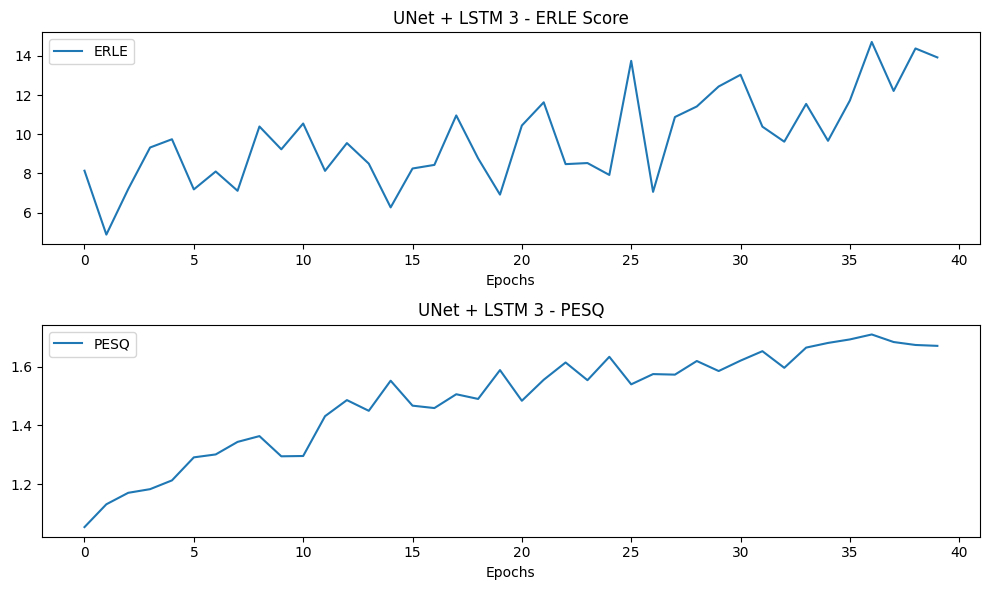

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### PESQ + ERLE

In [11]:
def train_UNet(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    criterion_mse  = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase, near_wave in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            # MSE Loss, PESQ and ERLE calc and loss
            mse_loss = criterion_mse(outputs, near)
            outputs_np = outputs.detach().cpu().numpy()
            near_wave_np = near_wave.clone()
            near_phase_np = near_phase.numpy()
            erle_avg, pesq_avg = functions.erle_pesq(outputs_np, near_wave_np, near_phase_np)
            erle_loss = torch.tensor(-erle_avg, requires_grad=True).to(device) # for backprop
            pesq_loss = torch.tensor(-pesq_avg, requires_grad=True).to(device)
            loss = (mse_loss * 0.2) + (erle_loss * 0.4) + (pesq_loss * 0.4)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        near_phase = near_phase.cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        
        erle_avg, pesq_avg = functions.erle_pesq(outputs, near_wave, near_phase)
        erle_arr.append(erle_avg)
        pesq_arr.append(pesq_avg)
        
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {total_loss/len(train_loader):.4f}, Duration: {duration}, ERLE Score: {erle_avg:.2f}, PESQ Score: {pesq_avg:.2f}")


In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350, 400]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)
        self.encoder_conv5 = self._double_conv(features[3], features[4])
        self.encoder_pool5 = nn.MaxPool1d(2)

        # Bottleneck
        self.frequency_lstm = icrn.FrequencyWiseLSTM(features[4], self.hidden_size)
        
        # Decoder (Upsampling path)
        self.decoder_up5 = nn.ConvTranspose1d(features[4] * 2, features[4], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv5 = self._double_conv(features[4] * 2, features[3])
        self.decoder_up4 = nn.ConvTranspose1d(features[3], features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3] * 2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2] * 2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1] * 2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0] * 2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        enc5 = self.encoder_conv5(pool4)
        pool5 = self.encoder_pool5(enc5)
        
        # # Bottleneck
        pool5_T = pool5.transpose(1, 2) # (batch, T, features)
        bottleneck = self.frequency_lstm(pool5_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck.transpose(1,2) # (batch, features, T)
        
        # # Decoder with skip connections
        dec5 = self.decoder_up5(bottleneck_T)
        dec5 = self.decoder_conv5(torch.cat([dec5, enc5], dim=1))  # Concatenate skip connection
        dec4 = self.decoder_up4(dec5)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [8]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = UNet().to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 200, 512]             --
│    └─Conv1d: 2-1                       [1, 200, 512]             462,800
│    └─BatchNorm1d: 2-2                  [1, 200, 512]             400
│    └─ReLU: 2-3                         [1, 200, 512]             --
│    └─Conv1d: 2-4                       [1, 200, 512]             120,200
│    └─BatchNorm1d: 2-5                  [1, 200, 512]             400
│    └─ReLU: 2-6                         [1, 200, 512]             --
├─MaxPool1d: 1-2                         [1, 200, 256]             --
├─Sequential: 1-3                        [1, 250, 256]             --
│    └─Conv1d: 2-7                       [1, 250, 256]             150,250
│    └─BatchNorm1d: 2-8                  [1, 250, 256]             500
│    └─ReLU: 2-9                         [1, 250, 256]             

In [15]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=0.01, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/40] Train Loss: -13.3395, Duration: 4 minutes 17 seconds, ERLE Score: 29.88, PESQ Score: 1.07
[Epoch   2/40] Train Loss: -13.0298, Duration: 2 minutes 58 seconds, ERLE Score: 33.04, PESQ Score: 1.08
[Epoch   3/40] Train Loss: -12.7750, Duration: 3 minutes 32 seconds, ERLE Score: 30.18, PESQ Score: 1.09
[Epoch   4/40] Train Loss: -12.4944, Duration: 4 minutes 40 seconds, ERLE Score: 27.14, PESQ Score: 1.13
[Epoch   5/40] Train Loss: -11.9375, Duration: 4 minutes 29 seconds, ERLE Score: 30.42, PESQ Score: 1.14
[Epoch   6/40] Train Loss: -11.5799, Duration: 4 minutes 31 seconds, ERLE Score: 27.98, PESQ Score: 1.17
[Epoch   7/40] Train Loss: -11.4217, Duration: 4 minutes 30 seconds, ERLE Score: 27.76, PESQ Score: 1.19
[Epoch   8/40] Train Loss: -11.2807, Duration: 4 minutes 25 seconds, ERLE Score: 25.61, PESQ Score: 1.22
[Epoch   9/40] Train Loss: -11.1662, Duration: 4 minutes 16 seconds, ERLE Score: 28.42, PESQ Score: 1.24
[Epoch  10/40] Train Loss: -11.0954, Duration: 4 minute

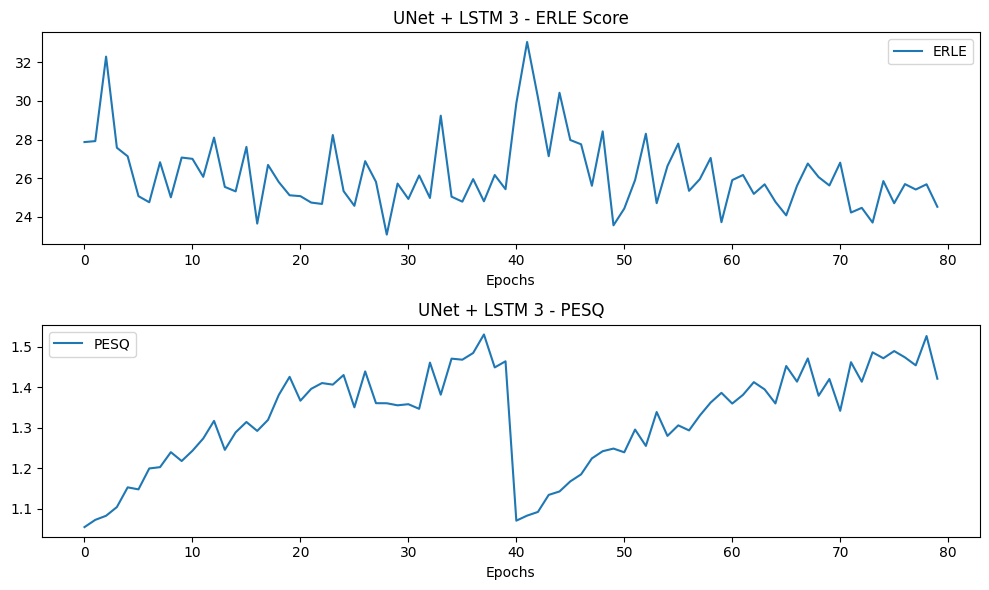

In [16]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### UNET_FreqLSTM_BN_5Layers 2

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350, 400]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)
        self.encoder_conv5 = self._double_conv(features[3], features[4])
        self.encoder_pool5 = nn.MaxPool1d(2)

        # Bottleneck
        self.frequency_lstm = icrn.FrequencyWiseLSTM(features[4], self.hidden_size)
        
        # Decoder (Upsampling path)
        self.decoder_up5 = nn.ConvTranspose1d(features[4] * 2, features[4], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv5 = self._double_conv(features[4] * 2, features[3])
        self.decoder_up4 = nn.ConvTranspose1d(features[3], features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3] * 2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2] * 2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1] * 2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0] * 2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        enc5 = self.encoder_conv5(pool4)
        pool5 = self.encoder_pool5(enc5)
        
        # # Bottleneck
        pool5_T = pool5.transpose(1, 2) # (batch, T, features)
        bottleneck = self.frequency_lstm(pool5_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck.transpose(1,2) # (batch, features, T)
        
        # # Decoder with skip connections
        dec5 = self.decoder_up5(bottleneck_T)
        dec5 = self.decoder_conv5(torch.cat([dec5, enc5], dim=1))  # Concatenate skip connection
        dec4 = self.decoder_up4(dec5)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 8
num_epochs = 40
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet(features = [300, 350, 400, 450, 500]).to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 300, 512]             --
│    └─Conv1d: 2-1                       [1, 300, 512]             694,200
│    └─BatchNorm1d: 2-2                  [1, 300, 512]             600
│    └─ReLU: 2-3                         [1, 300, 512]             --
│    └─Conv1d: 2-4                       [1, 300, 512]             270,300
│    └─BatchNorm1d: 2-5                  [1, 300, 512]             600
│    └─ReLU: 2-6                         [1, 300, 512]             --
├─MaxPool1d: 1-2                         [1, 300, 256]             --
├─Sequential: 1-3                        [1, 350, 256]             --
│    └─Conv1d: 2-7                       [1, 350, 256]             315,350
│    └─BatchNorm1d: 2-8                  [1, 350, 256]             700
│    └─ReLU: 2-9                         [1, 350, 256]             

In [ ]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

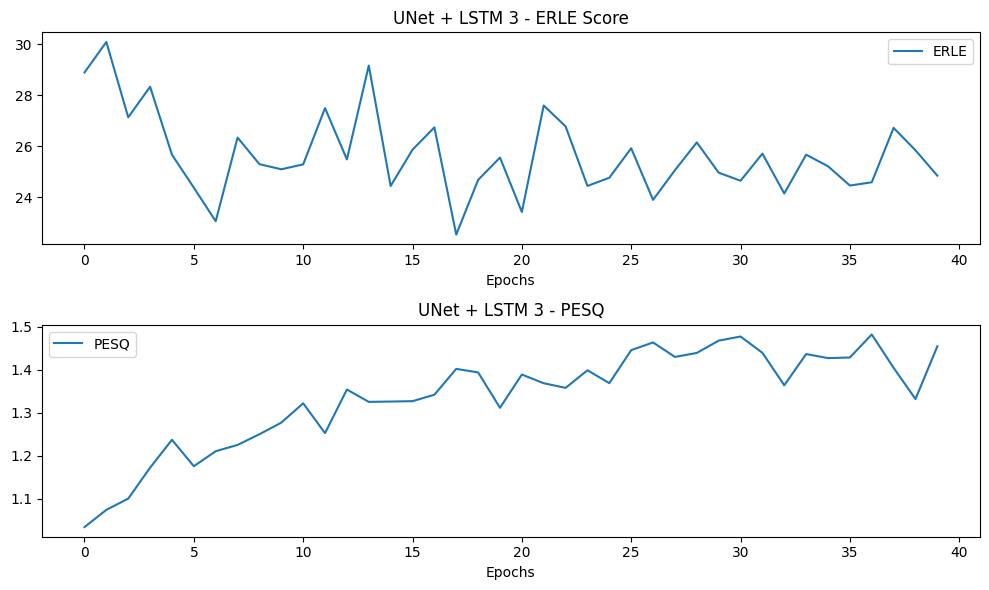

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("UNet + LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

##### UNETBN_5Layers

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350, 400]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)
        self.encoder_conv5 = self._double_conv(features[3], features[4])
        self.encoder_pool5 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck_conv = self._double_conv(features[4], features[4] * 2)
        
        # Decoder (Upsampling path)
        self.decoder_up5 = nn.ConvTranspose1d(features[4] * 2, features[4], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv5 = self._double_conv(features[4] * 2, features[3])
        self.decoder_up4 = nn.ConvTranspose1d(features[3], features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3] * 2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2] * 2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1] * 2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0] * 2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        enc5 = self.encoder_conv5(pool4)
        pool5 = self.encoder_pool5(enc5)
        
        # # Bottleneck
        bottleneck_T = self.bottleneck_conv(pool5)
        
        # # Decoder with skip connections
        dec5 = self.decoder_up5(bottleneck_T)
        dec5 = self.decoder_conv5(torch.cat([dec5, enc5], dim=1))  # Concatenate skip connection
        dec4 = self.decoder_up4(dec5)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [6]:
batch_size = 8
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length, window=1)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = UNet(features = [300, 350, 400, 450, 500]).to(device)
summary(model, (771, 512), batch_dim=0)

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 257, 512]             --
├─Sequential: 1-1                        [1, 300, 512]             --
│    └─Conv1d: 2-1                       [1, 300, 512]             694,200
│    └─BatchNorm1d: 2-2                  [1, 300, 512]             600
│    └─ReLU: 2-3                         [1, 300, 512]             --
│    └─Conv1d: 2-4                       [1, 300, 512]             270,300
│    └─BatchNorm1d: 2-5                  [1, 300, 512]             600
│    └─ReLU: 2-6                         [1, 300, 512]             --
├─MaxPool1d: 1-2                         [1, 300, 256]             --
├─Sequential: 1-3                        [1, 350, 256]             --
│    └─Conv1d: 2-7                       [1, 350, 256]             315,350
│    └─BatchNorm1d: 2-8                  [1, 350, 256]             700
│    └─ReLU: 2-9                         [1, 350, 256]             

In [11]:
train_UNet(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0007, Duration: 11 seconds, ERLE Score: 27.49, PESQ Score: 1.19
[Epoch   2/30] Train Loss: 0.0006, Duration: 11 seconds, ERLE Score: 27.29, PESQ Score: 1.22
[Epoch   3/30] Train Loss: 0.0006, Duration: 11 seconds, ERLE Score: 27.17, PESQ Score: 1.27
[Epoch   4/30] Train Loss: 0.0006, Duration: 11 seconds, ERLE Score: 26.82, PESQ Score: 1.26
[Epoch   5/30] Train Loss: 0.0005, Duration: 11 seconds, ERLE Score: 27.11, PESQ Score: 1.29
[Epoch   6/30] Train Loss: 0.0005, Duration: 11 seconds, ERLE Score: 26.79, PESQ Score: 1.27
[Epoch   7/30] Train Loss: 0.0005, Duration: 11 seconds, ERLE Score: 26.76, PESQ Score: 1.31
[Epoch   8/30] Train Loss: 0.0005, Duration: 11 seconds, ERLE Score: 26.47, PESQ Score: 1.31
[Epoch   9/30] Train Loss: 0.0005, Duration: 11 seconds, ERLE Score: 26.52, PESQ Score: 1.28
[Epoch  10/30] Train Loss: 0.0004, Duration: 11 seconds, ERLE Score: 27.35, PESQ Score: 1.34
[Epoch  11/30] Train Loss: 0.0004, Duration: 11 seconds, ERLE Score: 2

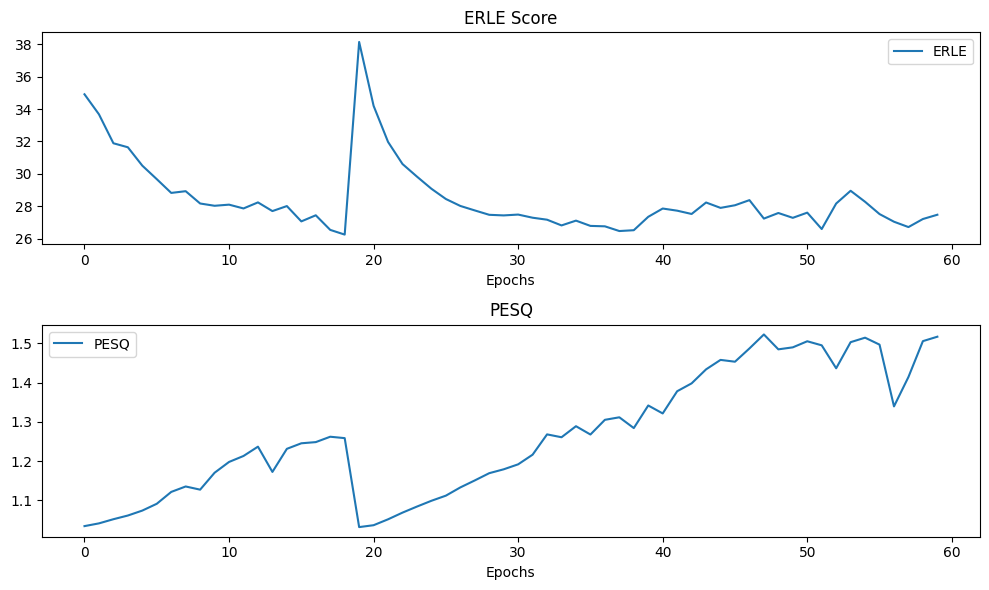

In [12]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("PESQ")
plt.legend()

plt.tight_layout()
plt.show()

#### Model Evaluation

In [4]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [200, 250, 300, 350, 400]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)
        self.encoder_conv5 = self._double_conv(features[3], features[4])
        self.encoder_pool5 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck_conv = self._double_conv(features[4], features[4] * 2)
        
        # Decoder (Upsampling path)
        self.decoder_up5 = nn.ConvTranspose1d(features[4] * 2, features[4], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv5 = self._double_conv(features[4] * 2, features[3])
        self.decoder_up4 = nn.ConvTranspose1d(features[3], features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3] * 2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2] * 2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1] * 2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0] * 2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        enc5 = self.encoder_conv5(pool4)
        pool5 = self.encoder_pool5(enc5)
        
        # # Bottleneck
        bottleneck_T = self.bottleneck_conv(pool5)
        
        # # Decoder with skip connections
        dec5 = self.decoder_up5(bottleneck_T)
        dec5 = self.decoder_conv5(torch.cat([dec5, enc5], dim=1))  # Concatenate skip connection
        dec4 = self.decoder_up4(dec5)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [16]:
# torch.save(model, "./models/UNET_5.pth")

In [5]:
model = torch.load("./models/UNET_5.pth")
model = model.to('cuda') 
model.eval()


UNet(
  (encoder_conv1): Sequential(
    (0): Conv1d(771, 300, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(300, 300, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder_pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv2): Sequential(
    (0): Conv1d(300, 350, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(350, 350, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder_pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=

In [8]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase, near_wave) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
near_wave = near_wave[:130816]
combined_input = combined.unsqueeze(0)
combined_input.shape, near_mag.shape, phase.shape

(torch.Size([1, 771, 512]), torch.Size([257, 512]), torch.Size([257, 512]))

In [9]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu() 
output_wave = outputs * phase
output_wave = librosa.istft(output_wave.numpy(), n_fft=512, hop_length=256)[:130816]
outputs.shape, output_wave.shape, near_wave.shape

(torch.Size([257, 512]), (130816,), (130816,))

##### Spectogram Plot

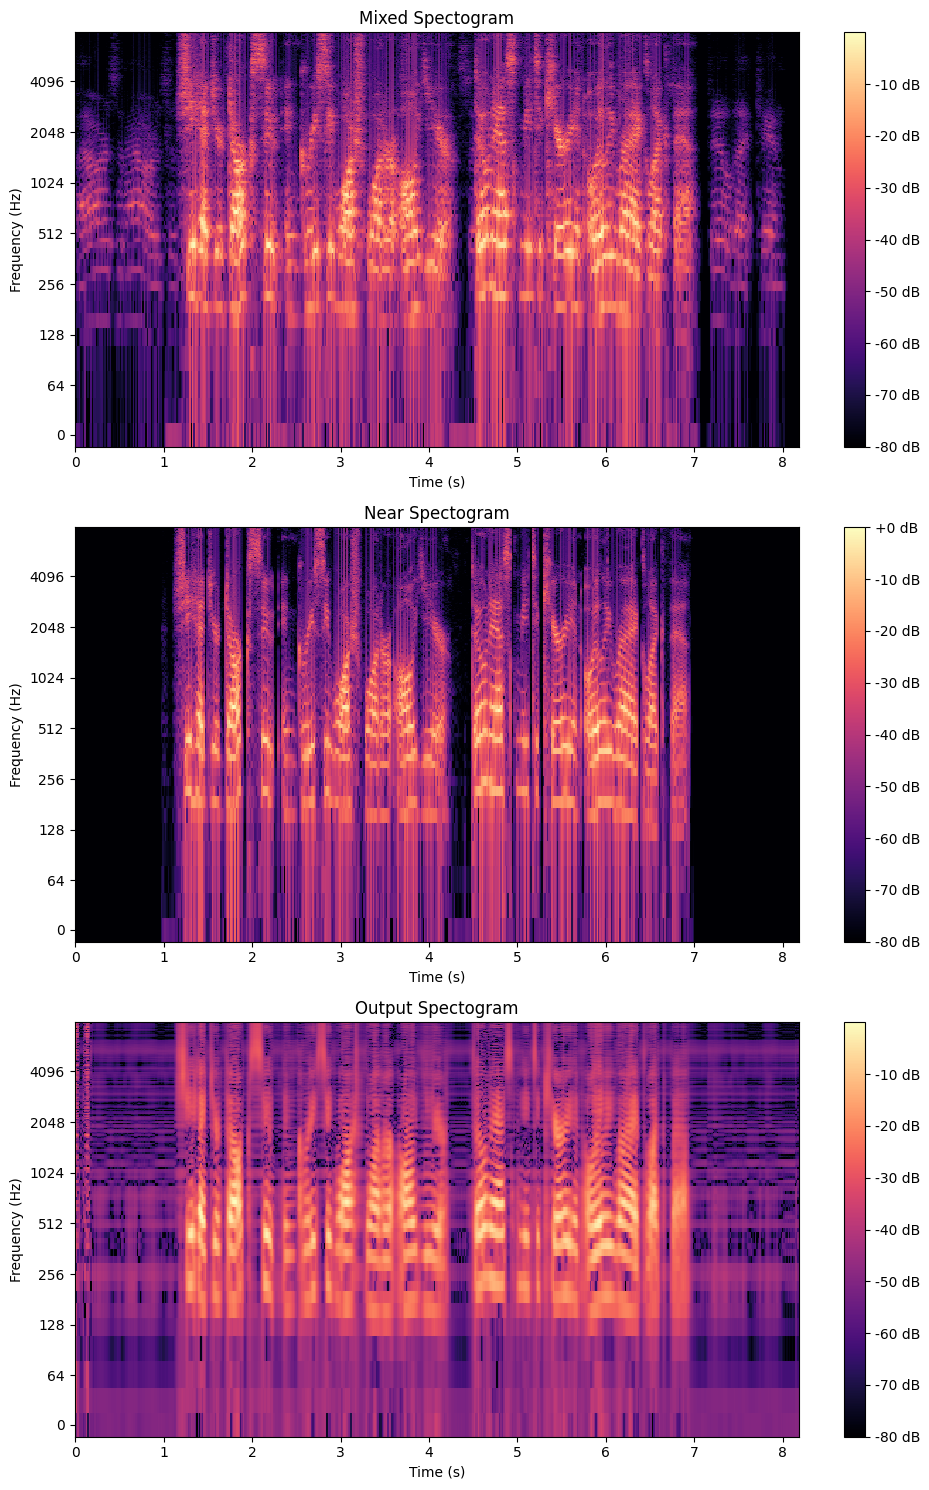

In [11]:
data = [mixed_mag, near_mag, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

In [113]:
erle_score = functions.compute_erle(near_wave, output_wave)
pesq_score = pesq(16000, near_wave, output_wave)
print(f"ERLE score: {erle_score:.2f}")
print(f"PESQ score: {pesq_score:.2f}")



ERLE score: 27.83
PESQ score: 1.56


## NSD Paper Implementation

In [4]:
def train_UNet(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    smooth_l1_loss_criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase, near_wave in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 3*257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            sisnr = functions.sisnr_loss(outputs, near)
            smooth_l1_loss = smooth_l1_loss_criterion(outputs, near)
            smooth_l1_loss.backward()
            optimizer.step()
            total_loss += smooth_l1_loss.item()
        
        near_phase = near_phase.cpu().numpy()
        outputs = outputs.detach().cpu().numpy()
        
        erle_avg, pesq_avg = functions.erle_pesq(outputs, near_wave, near_phase)
        erle_arr.append(erle_avg)
        pesq_arr.append(pesq_avg)
        
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {total_loss/len(train_loader):.4f}, Duration: {duration}, ERLE Score: {erle_avg:.2f}, PESQ Score: {pesq_avg:.2f}")


In [6]:
def get_mask(clean_signal, threshold=1e-6):
    if (type(clean_signal) == torch.Tensor):
        ideal_mask = torch.where(clean_signal >= threshold, torch.tensor(1.0), torch.tensor(0.0)).to(torch.float32) # for mask either 0 or 1
    else:
        ideal_mask = np.where(clean_signal >= threshold, 1.0, 0.0).astype(np.float32)
    return ideal_mask

In [5]:
class CRN_1D(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CRN_1D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU())
        self.lstm = nn.LSTM(512, 512, num_layers=2, bidirectional=True, batch_first=True)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1024, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(32, output_channels, kernel_size=5, stride=2, padding=2, output_padding=1),)

    def forward(self, x):
        x = self.encoder(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)
        x = self.decoder(x)
        return x

class LSTM_NSD_1D(nn.Module):
    def __init__(self, input_features, lstm_hidden_size, num_lstm_layers):
        super(LSTM_NSD_1D, self).__init__()
        self.lstm = nn.LSTM(
            input_features,
            lstm_hidden_size,
            num_layers=num_lstm_layers,
            bidirectional=False,
            batch_first=True,
        )
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        batch_size, num_channels, seq_length = x.size()
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        x = x.repeat(1, 1, num_channels)
        output = x.permute(0, 2, 1)
        return output

class AEC_System_1D(nn.Module):
    def __init__(self, crn_in_channels, crn_out_channels, lstm_nsd_in_features):
        super(AEC_System_1D, self).__init__()
        self.crn = CRN_1D(crn_in_channels, crn_out_channels)
        self.lstm_nsd = LSTM_NSD_1D(lstm_nsd_in_features)

    def forward(self, crn_input, lstm_nsd_input):
        # CRN
        estimated_output = self.crn(crn_input)
        print(estimated_output.shape)
        # LSTM_NSD
        nsd_mask = self.lstm_nsd(lstm_nsd_input)
        print(nsd_mask.shape)
        return estimated_output, nsd_mask

In [7]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase, near_wave) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
near_wave = near_wave[:130816]
combined_input = combined.unsqueeze(0)
combined_input.shape, near_mag.shape, phase.shape

(torch.Size([1, 771, 512]), torch.Size([257, 512]), torch.Size([257, 512]))

In [10]:
get_mask(near_mag).shape

torch.Size([257, 512])

In [ ]:
model = = AEC_System_1D(
    crn_in_channels=input_channels,
    crn_out_channels=output_channels,
    lstm_nsd_in_features=514  # Adjust based on your actual input
)
estimated_output, nsd_mask = model(crn_input_data, lstm_nsd_input_data)

In [ ]:
def train_aec_1d(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda"):
    crn_criterion = nn.MSELoss()  # Mean Squared Error for complex spectrogram estimation
    nsd_criterion = nn.MSELoss()  #  or nn.BCELoss() # MSE Loss or Binary Cross Entropy for NSD
    crn_optimizer = optim.Adam(model.crn.parameters(), lr=learning_rate)
    nsd_optimizer = optim.Adam(model.lstm_nsd.parameters(), lr=learning_rate)

    model.to(device)
    for epoch in range(num_epochs):
        start_time = time.time()
        total_crn_loss = 0.0
        total_nsd_loss = 0.0

        for mixed, far, near in train_loader:
            mixed = mixed.to(device)  # [batch_size, num_channels, sequence_length]
            far = far.to(device)      # [batch_size, num_channels, sequence_length]
            near = near.to(device)    # [batch_size, num_channels, sequence_length]

            crn_optimizer.zero_grad()

            crn_input = torch.cat((mixed, far), dim=1)  # [batch_size, num_channels*2, sequence_length]
            estimated_near, _ = model(crn_input, mixed) # We are not using NSD output here

            crn_loss = crn_criterion(estimated_near, near)
            crn_loss.backward()
            crn_optimizer.step()

            total_crn_loss += crn_loss.item()

            nsd_optimizer.zero_grad()

            nsd_input = mixed # Or you can concatenate mixed and far like CRN input
            _, nsd_mask = model(mixed, nsd_input) # We are not using CRN output here

            nsd_target = get_nsd_target(near).to(device)  # Implement this function

            nsd_loss = nsd_criterion(nsd_mask, nsd_target)
            nsd_loss.backward()
            nsd_optimizer.step()

            total_nsd_loss += nsd_loss.item()

        epoch_crn_loss = total_crn_loss / len(train_loader)
        epoch_nsd_loss = total_nsd_loss / len(train_loader)
        duration = functions.timeit(start_time)

        print(
            f"[Epoch {epoch + 1:3d}/{num_epochs:2d}] "
            f"CRN Loss: {epoch_crn_loss:.4f}, "
            f"NSD Loss: {epoch_nsd_loss:.4f}, "
            f"Duration: {duration}"
        )